In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import norm, probplot
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt

import winsound
import time

In [3]:
duration = 5000  # milliseconds
freq = 440  # Hz

#### Função para calcular o score do no modelo

In [4]:
def rmse(y_true, preds):
    return mse(y_true, preds, squared=False)
    
def score_(X_train, X_valid, y_train, y_valid, model = LinearRegression(n_jobs=5)):
    '''
    Score model with root mean squared error (RMSE)
    '''
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return rmse(y_valid, preds)
#     return mae(y_valid, preds)

In [5]:
# carregando o dataset, a extração é do dataset disponível em: https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019?resource=download
# Lembrando que também conseguimos utilizar o algoritmo de extração direto de sistemas de alguel.

In [6]:
df = pd.read_csv('data/sao-paulo-properties-april-2019.csv')
df.head(3)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665


In [7]:
df[['District', 'City']] = df.District.str.split('/', expand=True)
df.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude,City
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.543138,-46.479486,São Paulo
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.550239,-46.480718,São Paulo
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.542818,-46.485665,São Paulo
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim,rent,apartment,-23.547171,-46.483014,São Paulo
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim,rent,apartment,-23.525025,-46.482436,São Paulo


Price - Valor do imóvel em Reais (BRL)

Condo - Custo do condomínio em Reais (BRL)

Size - Area do imóvel em metros quadrados M²

Rooms - Número de quartos

Toilets - Total de banheiros

Suites - Total de quartos com banheiros

Parking - Número de vagas de estacionamento

Elevator - Valor binário se existe elevador

Furnished- Se o imóvel é ou não mobiliado

Swimming Pool - Existe ou não piscina

New = Imóvel é novo

District - Bairro e cidade onde o imóvel está localizado

Negotiation Type - Tipo de necociação (aluguel, venda...)

Property Type - Tipo de imóvel (apartamento, casa)

Latitude - posição geográfica

Longitude - posição geográfica

City - Cidade

## Vamos filtrar os campos, pois queremos apenas valores de aluguel, para apartamentos

In [8]:
df['Negotiation Type'].value_counts()

rent    7228
sale    6412
Name: Negotiation Type, dtype: int64

In [9]:
df = df[df['Negotiation Type'] == 'rent']

In [10]:
df['Property Type'].value_counts()

apartment    7228
Name: Property Type, dtype: int64

## Quais são os dados nulos?

In [11]:
df.isna().sum().sort_values()

Price               0
Latitude            0
Property Type       0
Negotiation Type    0
District            0
New                 0
Swimming Pool       0
Longitude           0
Furnished           0
Parking             0
Suites              0
Toilets             0
Rooms               0
Size                0
Condo               0
Elevator            0
City                0
dtype: int64

# Quantos bairros tempos?

In [12]:
df['District'].nunique()

94

# Quais os bairros com mais mais disponibilidade?

In [13]:
df['District'].value_counts().sort_values(ascending=False).to_frame().head(10)

,District
Mooca,178
Moema,163
Vila Mariana,161
Morumbi,159
Pinheiros,153
Cambuci,153
Butantã,152
Vila Leopoldina,148
Itaim Bibi,144
Jardim Paulista,141


In [14]:
# df= df[df.Preco < 50000].reset_index(drop=True)#.sort_values(by=['Preco'], ascending=False)
# df = df[df.Quartos < 6]

### Qual a médica de cada bairro?

In [15]:
df.groupby(['District'], as_index=False).Price.median().sort_values(by='Price', ascending=False)

,District,Price
31,Iguatemi,7200.0
33,Itaim Bibi,6500.0
40,Jardim Paulista,6000.0
90,Vila Olimpia,5500.0
0,Alto de Pinheiros,5000.0
...,...,...
45,Lajeado,925.0
39,Jardim Helena,910.0
44,José Bonifácio,900.0
34,Itaim Paulista,825.0


Vamos pegar uma amostra de valores aleatórios no dataframe.

In [16]:
test_sample = df.sample(10)
df = df.drop(test_sample.index).reset_index(drop=True)

<AxesSubplot:title={'center':'Correlação entre as variáveis'}>

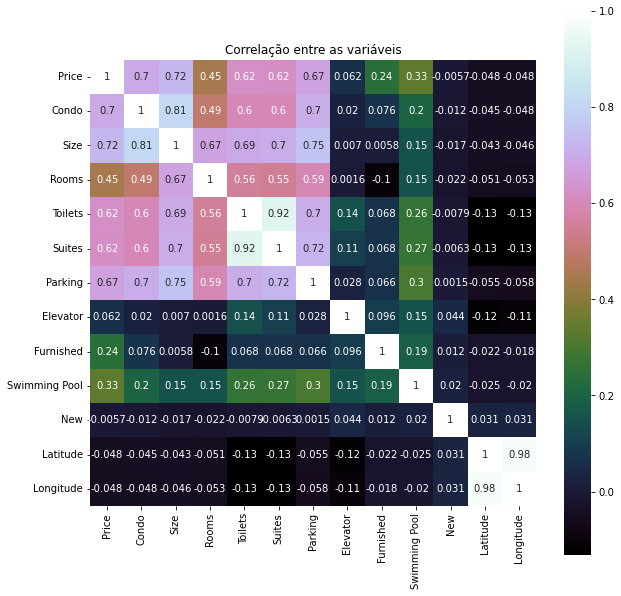

In [89]:
correlation = df.corr()
plt.figure(figsize=(10,10))
plt.title('Correlação entre as variáveis')
sns.heatmap(correlation, square=True,annot=True,cmap='cubehelix')

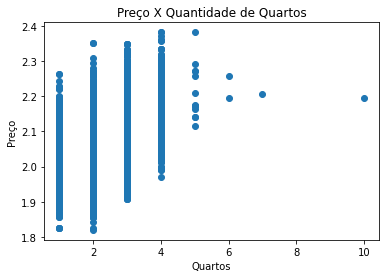

In [86]:
fig, ax= plt.subplots()
ax.scatter(x=df['Rooms'], y=np.log(df['Price']))
plt.ylabel('Preço')
plt.xlabel('Quartos')
plt.title("Preço X Quantidade de Quartos")
plt.show()

C:\Users\Alexandre\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


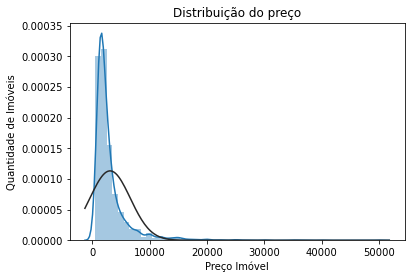

In [18]:
sns.distplot(df.Price, fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Distribuição do preço')
plt.show()

Vamos ajustar o preço para uma distribuição `normal`

C:\Users\Alexandre\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


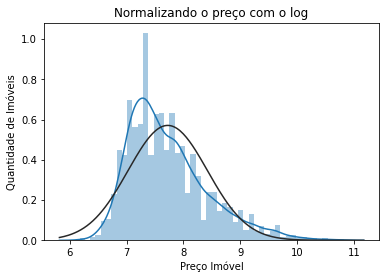

In [19]:
sns.distplot(np.log(df.Price), fit=norm)
plt.xlabel('Preço Imóvel')
plt.ylabel('Quantidade de Imóveis')
plt.title('Normalizando o preço com o log')
plt.show()

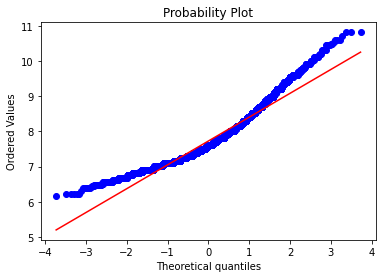

In [20]:
probplot(np.log(df.Price), plot=plt)
plt.show()

In [21]:
df.Price = np.log(df.Price)

In [22]:
df.District = df.District.astype("category")

In [23]:
X = df.drop(columns=['Price','Negotiation Type', 'Property Type', 'Latitude', 'Longitude', 'City'])
y = df['Price']

In [24]:
# Vamos criar nossa base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# Vamos criar uma cópia para evitar alterações
label_X_train = X_train.copy()
label_X_test = X_test.copy()

# Vamos aplicar o OrdinarEnconder para a coluna categoria, que no caso é apenas o bairro
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

label_X_train[['District']] = ordinal_encoder.fit_transform(X_train[['District']].values)
label_X_test[['District']] = ordinal_encoder.transform(X_test[['District']].values)

print("RMSE com OrdinalEnconder:") 
print(score_(label_X_train, label_X_test, y_train, y_test))

RMSE com OrdinalEnconder:
0.42428157493106816


In [25]:
scores = cross_val_score(LinearRegression(fit_intercept=False, n_jobs=1, positive=True), label_X_train, y_train, cv=5)
scores

array([-6.58286218, -6.96642864, -6.97372867, -7.60001017, -6.73255881])

In [26]:

n_estimators = 5
pipe = Pipeline(steps=[
    #('preprocessor', SimpleImputer()),
    ("normalizacao", MinMaxScaler()),
    ('model', LinearRegression(n_jobs=5))
])
scores = -1 * cross_val_score(pipe, label_X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')
scores

array([0.31327667, 0.3073842 , 0.3088308 , 0.31615245, 0.31175812])

In [ ]:
#Cuidado essa tarefa leva cerca de 50 minutos
start=time.time()
clf = GridSearchCV(RandomForestRegressor(), {'n_estimators': [100, 250, 700],
#                                        'criterion': ["squared_error", "absolute_error", "poisson"],
                                       'max_depth': [3, 13, 50],
                                       'min_samples_split': [2, 5, 10],
                                       'min_samples_leaf': [2, 6, 10, 15],
                                       'n_jobs': [2, 5, 15],
                                         'verbose': [3]
                                            },
                  scoring='neg_root_mean_squared_error',
                  cv=5,
                  error_score='raise')
# clf.fit(label_X_train, y_train)
clf.fit(df_pca, y_train)
winsound.Beep(freq, duration)
print(np.round(time.time()-start, 2))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[P

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 228 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    4.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed: 

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    4.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent w

[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks     

[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 700 out of 700 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.0s
[Paral

[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=15)]: Using ba

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 209 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 221 out of 250 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 218 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=15)]: Done 123 tasks      | elapsed:    4.0s
[Parallel(n_jobs=15)]: Done 588 tasks      | elapsed:    4.4s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    4.6s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.5s fi

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent worker

[Parallel(n_jobs=15)]: Done 203 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 700 out of 700 | elapsed:    0.0s

[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.4s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.0s finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 274 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done 700 out of 700 | elapsed:    0.8s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elaps

[Parallel(n_jobs=2)]: Done 206 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 206 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 206 tasks      | 

In [31]:
clf.best_estimator_

RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700,
                      n_jobs=5, verbose=3)

### Quais os melhores hiperparametros?

`RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700, n_jobs=5, verbose=3)`

In [124]:
n_estimators = 5
pipe = Pipeline(steps=[
    ("normalizacao", StandardScaler()),
    ('PCA', PCA(n_components=7)),
    ('model', RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700,
                      n_jobs=5, verbose=0))
])
scores = -1 * cross_val_score(pipe, label_X_train, y_train,
                          cv=5,
                          scoring='neg_mean_absolute_error')
scores

array([0.27922035, 0.27953804, 0.28943313, 0.27140072, 0.2641163 ])

In [125]:
pipe.fit(label_X_test.values, y_test)

Pipeline(steps=[('normalizacao', StandardScaler()),
                ('PCA', PCA(n_components=7)),
                ('model',
                 RandomForestRegressor(max_depth=50, min_samples_leaf=2,
                                       n_estimators=700, n_jobs=5))])

In [126]:
pipe.score(label_X_test.values, y_test)

0.9310855526156971

In [127]:
np.exp(score_(label_X_train, label_X_test, y_train, y_test,RandomForestRegressor(max_depth=50, min_samples_leaf=2, n_estimators=700,
                      n_jobs=5, verbose=0)))

1.3942258205039122

### PCA

In [115]:
ss = StandardScaler()
ss.fit(label_X_train)
df_standard_train = ss.transform(label_X_train)

pca = PCA(n_components=7)
pca.fit(df_standard)
print(f"PCA - Explained CumSum: {np.round(pca.explained_variance_ratio_.cumsum(), decimals=2)}")

PCA - Explained CumSum: [0.42 0.55 0.65 0.74 0.82 0.88 0.92]


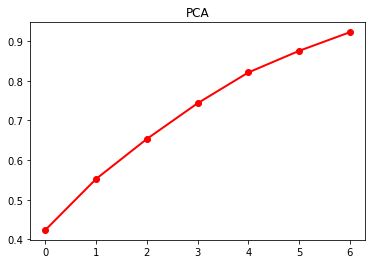

In [116]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
plt.title('PCA')
plt.show()

In [113]:
pca_res = pca.fit_transform(df_standard)

In [114]:
df_pca = pd.DataFrame(pca_res, columns=[f"COL_{x}" for x in range(pca_res.shape[1])])

Como temos poucas colunas, vamos manter as 5 colunas inicias

In [660]:
from joblib import dump, load

In [678]:
dump(pipe, 'models\pipe_rfr.joblib')
dump(ordinal_encoder, 'models\ordinal_encoder.joblib')

['models\\ordinal_encoder.joblib']

In [679]:
ordinal_encoder = load('models\ordinal_encoder.joblib')

In [38]:
# df.groupby([''], as_index=False).ID.count().sort_values(by='ID', ascending=False).head(20)

In [47]:
test_district = test_sample['District']

In [39]:
test_sample[['District']] = ordinal_encoder.fit_transform(test_sample[['District']])

In [40]:
test_sample_true = test_sample['Price']

In [41]:
test_sample.drop(columns=['Price','Negotiation Type', 'Property Type', 'Latitude', 'Longitude', 'City'],  inplace=True)

In [43]:
ordinal_encoder.transform([['Pinheiros']])

C:\Users\Alexandre\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


array([[-1.]])

In [50]:
test_sample = test_sample.reset_index(drop=True)

In [51]:
test_sample.iloc[0].T

Condo            300.0
Size              60.0
Rooms              2.0
Toilets            1.0
Suites             0.0
Parking            1.0
Elevator           0.0
Furnished          0.0
Swimming Pool      0.0
New                0.0
District           5.0
Name: 0, dtype: float64

In [52]:
test_sample.iloc[0].to_frame().T

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
0,300.0,60.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0


In [65]:
test_sample

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
0,300,60,2,1,0,1,0,0,0,0,5.0
1,820,100,3,3,1,2,0,0,1,0,1.0
2,750,70,2,1,0,2,0,0,1,0,6.0
3,613,63,2,1,0,1,0,1,0,0,4.0
4,159,41,2,2,1,1,0,0,0,0,2.0
5,800,55,1,2,1,1,1,0,1,0,0.0
6,500,50,1,1,0,1,1,0,0,0,8.0
7,0,70,2,2,1,1,1,0,0,0,7.0
8,360,47,2,1,0,1,0,0,1,0,3.0
9,250,54,2,2,1,1,0,0,0,0,9.0


In [56]:
np.array([2.,1.,1.,51.,6.]).reshape((1,-1))

array([[ 2.,  1.,  1., 51.,  6.]])

In [66]:
pipe.predict(test_sample)

C:\Users\Alexandre\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


array([7.17526805, 7.95282168, 7.7570576 , 7.61392854, 6.94749814,
       7.94537048, 7.02062148, 7.16230299, 7.13685287, 6.95621829])

In [67]:
test_sample_true

3928     1000
1691     2800
4625     1600
3678     2000
9673      750
5256     3500
10769    1100
9989     1900
3093     1000
480      1100
Name: Price, dtype: int64

In [60]:
pipe.score(test_sample.values, np.log(test_sample_true))

0.744915303336511

In [61]:
test_sample

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
0,300,60,2,1,0,1,0,0,0,0,5.0
1,820,100,3,3,1,2,0,0,1,0,1.0
2,750,70,2,1,0,2,0,0,1,0,6.0
3,613,63,2,1,0,1,0,1,0,0,4.0
4,159,41,2,2,1,1,0,0,0,0,2.0
5,800,55,1,2,1,1,1,0,1,0,0.0
6,500,50,1,1,0,1,1,0,0,0,8.0
7,0,70,2,2,1,1,1,0,0,0,7.0
8,360,47,2,1,0,1,0,0,1,0,3.0
9,250,54,2,2,1,1,0,0,0,0,9.0
